In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset


In [3]:

from scipy.ndimage import zoom

In [2]:
print(torch.__version__)

2.3.0


In [4]:
root = '/Users/alexthomas/Desktop/PyTorch/data/train/'
file_list = [f for f in os.listdir(root) if f.endswith('.npz')]
print(len(file_list))

18866


before shape: (118, 164)
target shape: (118, 164)
arr shape: (118, 164)
(118, 164)
0.0


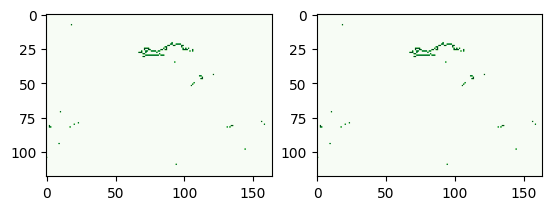

In [7]:
file = np.load(root + file_list[1])


arr = np.squeeze(file['array1'])

print(f'before shape: {arr.shape}')
shape = file['array1'].shape


print(f'target shape: {shape}')
print(f'arr shape: {arr.shape}')

out = zoom(arr, (shape[0]/ arr.shape[0], shape[1] / arr.shape[1]))
print(out.shape)

import matplotlib.pyplot as plt

# Plotting the arrays
fig = plt.figure()#figsize=(10, 10))

# Plotting the 'arr' array
ax = fig.add_subplot(1, 2, 1)
ax.imshow(n_0_and_1(arr), cmap='Greens')
ax.set_label('arr')

# Plotting the 'out' array
ax1 = fig.add_subplot(1, 2, 2)
ax1.imshow(n_0_and_1(out), cmap='Greens')
ax1.set_label('out')


print(np.min(n_0_and_1(out)))
#plt.tight_layout()
plt.show()


In [8]:
def n_0_and_1(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    denominator = arr_max - arr_min
    if denominator <= 0.01:
        return arr/(arr_max+1e-6)
    return (arr - arr_min) / (denominator)


def n_neg1_and_1(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    denominator = arr_max - arr_min
    if denominator <= 0.01:
        return arr/(arr_max+1e-6)
    return (2*(arr - arr_min) / (denominator + 1e-6)) - 1

In [9]:
arr = np.array([0,1,1,4,5,6])[:,np.newaxis]
print(np.rot90(arr))

f = np.rot90(zoom(arr, (2,5)))
print(f)

[[0 1 1 4 5 6]]
[[0 0 1 1 1 2 3 4 5 5 6 6]
 [0 0 1 1 1 2 3 4 5 5 6 6]
 [0 0 1 1 1 2 3 4 5 5 6 6]
 [0 0 1 1 1 2 3 4 5 5 6 6]
 [0 0 1 1 1 2 3 4 5 5 6 6]]


In [10]:
lst = np.load(root+file_list[0])
precip = lst['array5'] 
print(precip.shape)
print(precip[0])
precip = precip[0]

if len(precip.shape) == 3:
    precip = np.squeeze(precip)
    print(zoom(precip, (5,3)))
else:
    print(zoom(precip, (5,3)))

(4, 3, 1)
[[0.]
 [0.]
 [0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [11]:

def load_arrays(path):
    
    #input data
    data = np.load(path)
    pre_fl = n_0_and_1(data['array1'])
    pre_dob = n_0_and_1(data['array2'])

    #n arrays
    #precipitation has the largest resolution so it is probably the most likely to have this issue, but I did v comp and u comp as well
    
        
    v_comp = data['array3']
    u_comp = data['array4']
    precip = data['array5']

   
    v_comp = n_neg1_and_1(v_comp) if len(v_comp.shape) != 3 else  n_neg1_and_1(np.squeeze(v_comp))

    u_comp = n_neg1_and_1(u_comp) if len(u_comp.shape) != 3 else n_neg1_and_1(np.squeeze(u_comp))
   # print(precip.shape, v_comp.shape, u_comp.shape)
    
    
    if len(precip.shape) == 3:
        precip = n_0_and_1(precip.reshape(precip.shape[:-1]))
    else:
        print("This is useful")
        precip = n_0_and_1(precip)
        
    #elif len(precip.shape) == 1:
    #    precip = n_0_and_1(precip[:,np.newaxis]) 
    #else: 
    #    precip = n_0_and_1(precip)

    #print(precip.shape, v_comp.shape, u_comp.shape)
    
    cover =  n_0_and_1(np.squeeze(data['array6']))
    
   

    # post_fl = data['array7']
    post_dob = n_0_and_1(data['array8'])

    # Determine the target shape
    target_shape = pre_fl.shape  # or any other shape you want
    
    #print(post_dob.shape == target_shape)
    # Resize arrays
    
    v_comp = zoom(v_comp, (target_shape[0] / v_comp.shape[0], target_shape[1] / v_comp.shape[1]))
    u_comp = zoom(u_comp, (target_shape[0] / u_comp.shape[0], target_shape[1] / u_comp.shape[1]))

    precip = zoom(precip, (target_shape[0] / precip.shape[0], target_shape[1] / precip.shape[1]))
    cover = zoom(cover, (target_shape[0] / cover.shape[0], target_shape[1] / cover.shape[1]))
    inputs = np.stack((pre_fl, pre_dob, v_comp, u_comp, precip, cover), axis=0)
    return [inputs, post_dob]
    

In [12]:
file_name = file_list[0]
lst, outputs = load_arrays(root+file_name)





In [13]:


class NpzDataset(Dataset):
    def __init__(self, dir_path, transform=None):
        self.file_list = [f for f in os.listdir(dir_path) if f.endswith('.npz')]
        self.dir_path = dir_path
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.dir_path, self.file_list[idx])
        list = load_arrays(file_path)
        inputs = list[0]
        outputs = list[1]
       
        input_tensor = torch.from_numpy(inputs)
        output_tensor = torch.from_numpy(outputs)
        
        if self.transform:
            input_tensor = self.transform(input_tensor)
            output_tensor = self.transform(output_tensor)

        return input_tensor, output_tensor
    
       

In [14]:

import torch.nn as nn
import torch.nn.functional as F



In [15]:


class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        #could change other factors about this such as dialation and the stride
        self.encoder_conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.encoder_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.decoder_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.decoder_conv2 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.encoder_conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.encoder_conv2(x))
        x = F.max_pool2d(x, 2)

        # Decoder
            #This doubles the scale through interpolation
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        #non linearity
        x = F.relu(self.decoder_conv1(x))
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        #squishes between 0 and 1
        x = torch.sigmoid(self.decoder_conv2(x))

        return x

In [16]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence



#def collate_fn(batch):
#    # Separate sequences and labels
#    print(batch)
#    sequences, labels = zip(*batch)
#
#    # Get the maximum dimensions in the batch
#    max_dim1 = max([seq.shape[1] for seq in sequences])
#    max_dim2 = max([seq.shape[2] for seq in sequences])
#
#    # Pad sequences to match the maximum dimensions
#    sequences_padded = [torch.cat([seq, torch.zeros(6, max_dim1 - seq.shape[1], max_dim2)], dim=1) for seq in sequences]
#    labels_padded = [torch.cat([label, torch.zeros(6, max_dim1 - label.shape[1], max_dim2)], dim=1) for label in labels]
#
#    return torch.stack(sequences_padded), torch.stack(labels_padded)

def collate_fn(batch):
    # Separate sequences and labels
    sequences, labels = zip(*batch)

    # Get the maximum dimensions in the batch
    max_dim1 = max([seq.shape[1] for seq in sequences])
    max_dim2 = max([seq.shape[2] for seq in sequences])
    print(f'max dimension 2: {max_dim1}, max dimension 3: {max_dim2}')
    
    
  

    # Pad sequences to match the maximum dimensions
    sequences_padded = [torch.nn.functional.pad(seq, (0, max_dim2-seq.shape[2]+1, 0, max_dim1-seq.shape[1]+1, 0, 0)) for seq in sequences]
    labels_padded = [torch.nn.functional.pad(label,(0, max_dim2-label.shape[1], 0, max_dim1 - label.shape[0])) for label in labels]

    return torch.stack(sequences_padded), torch.stack(labels_padded)

In [36]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Instantiate your dataset

data = NpzDataset(root)

print(f"Number of items: {len(data)}")


# Create data loaders
data_loader = DataLoader(data, batch_size=32, collate_fn=collate_fn)

# Instantiate your model
model = FCN()

# Define a loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    keep_text = f"Epoch Number: {epoch}"
    for inputs, targets in data_loader:
        # Move data to the appropriate device if necessary
        #inputs = inputs.to(device)
       # targets = targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs.float())
        

        outputs = outputs.squeeze(1)
        
      
        
        if outputs.shape != targets.shape:
    
            t1 = time.time()
            
            #handle case for first dimension
            if outputs.shape[1] < targets.shape[1]:
                outputs = torch.nn.functional.pad(outputs, (0,0 , 0, targets.shape[1]-outputs.shape[1], 0, 0 ))
            if outputs.shape[1] > targets.shape[1]:
                outputs = outputs[:, :targets.shape[1], :]
           
           #handle case for second dimension
            if outputs.shape[2] < targets.shape[2]:
                outputs = torch.nn.functional.pad(outputs, (0, targets.shape[2]-outputs.shape[2], 0, 0, 0, 0))
            
            if outputs.shape[2] > targets.shape[2]:
                outputs = outputs[:, :, :targets.shape[2]]   
            
            t2 = time.time()
            print(t2-t1)
        
        
        
        # Calculate loss
        loss = criterion(outputs, targets.float())
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        display.clear_output()
        display.display(keep_text)
        for param_group in optimizer.param_groups:
          display.display(f"Learning rate: {param_group['lr']}")
        display.display(loss.item())
        
        losses.append(loss.item())

'Epoch Number: 6'

'Learning rate: 0.001'

0.02342686802148819

max dimension 2: 387, max dimension 3: 186
0.001291036605834961


KeyboardInterrupt: 

torch.save()

In [38]:
torch.save(model.state_dict(), 'model.pth')

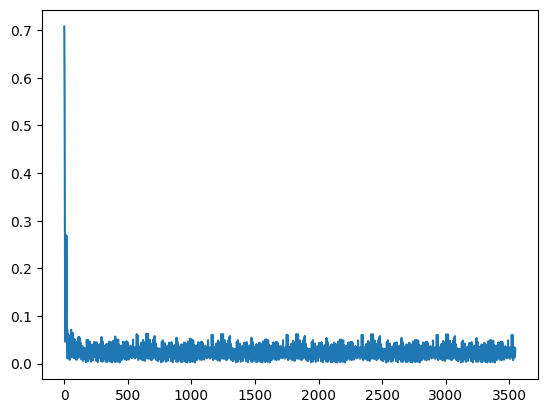

In [41]:
fig = plt.figure()
plt.plot(losses)

In [65]:
model.eval()
testdata = NpzDataset('/Users/alexthomas/Desktop/PyTorch/data/test')
testloader = DataLoader(testdata, batch_size=1, shuffle=False) 


correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.float())
        predicted = outputs.argmax(dim=1)
        
        print(f'shape of predicted {torch.nn.functional.pad(predicted, (0, labels.shape[2]-predicted.shape[2],0, labels.shape[1]-predicted.shape[1])).shape}')
        print(f'shape of labels: {labels.shape}')
        total += labels.size(1)*labels.size(2)
      
        correct += (torch.nn.functional.pad(predicted, (0, labels.shape[2]-predicted.shape[2],0, labels.shape[1]-predicted.shape[1])) == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

shape of predicted torch.Size([1, 42, 63])
shape of labels: torch.Size([1, 42, 63])
shape of predicted torch.Size([1, 65, 61])
shape of labels: torch.Size([1, 65, 61])
shape of predicted torch.Size([1, 58, 59])
shape of labels: torch.Size([1, 58, 59])
shape of predicted torch.Size([1, 72, 52])
shape of labels: torch.Size([1, 72, 52])
shape of predicted torch.Size([1, 65, 61])
shape of labels: torch.Size([1, 65, 61])
shape of predicted torch.Size([1, 54, 65])
shape of labels: torch.Size([1, 54, 65])
shape of predicted torch.Size([1, 48, 58])
shape of labels: torch.Size([1, 48, 58])
shape of predicted torch.Size([1, 48, 58])
shape of labels: torch.Size([1, 48, 58])
shape of predicted torch.Size([1, 54, 65])
shape of labels: torch.Size([1, 54, 65])
shape of predicted torch.Size([1, 52, 64])
shape of labels: torch.Size([1, 52, 64])
shape of predicted torch.Size([1, 65, 61])
shape of labels: torch.Size([1, 65, 61])
shape of predicted torch.Size([1, 36, 65])
shape of labels: torch.Size([1, 3

In [71]:
test = '/Users/alexthomas/Desktop/PyTorch/data/test/'
file_list = [f for f in os.listdir(test) if f.endswith('.npz')]
print(len(file_list))

inputs, outputs = np.load_test[0]


2384


(65, 61)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(64, 60)


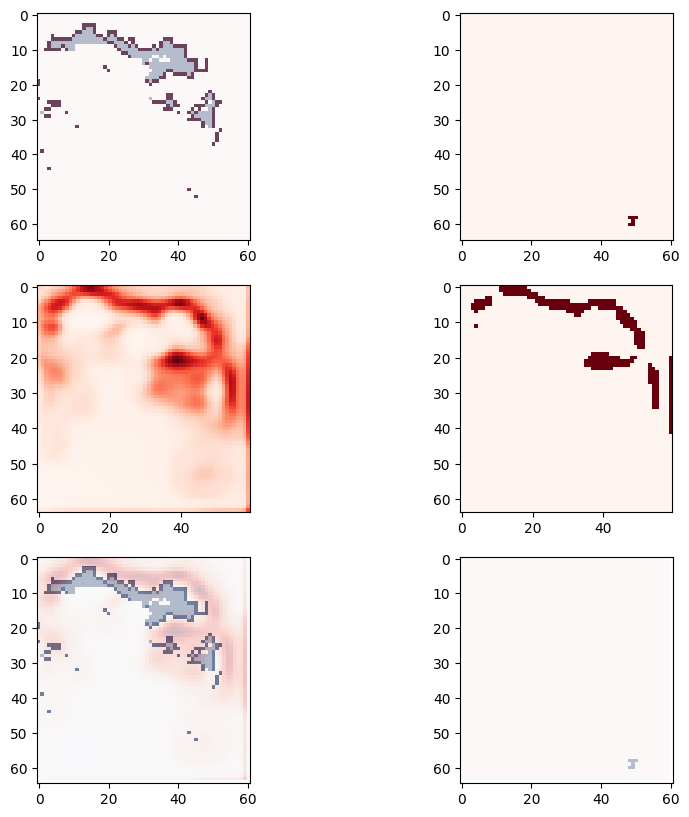

In [148]:
import matplotlib.pyplot as plt

# Get the i-th batch from the DataLoader
#interesting values: 155, 150, 350
i = 155 # replace with the index of the desired batch
for batch_index, (inputs, labels) in enumerate(testloader):
    if batch_index == i:
        break

# Get the j-th instance from the batch
j = 0  # replace with the index of the desired instance
instance = inputs[j]
label = labels[j]

# Assuming instance is a 3D tensor (channels, height, width)
#instance_image = instance.permute(1, 2, 0)  # Convert to (height, width, channels)
arr = instance[0].numpy()

print(arr.shape)
print(arr)


model.eval()
output = model(instance.unsqueeze(0).float())
print(output.detach().numpy().squeeze(0)[0].shape)

output_arr = output.detach().numpy().squeeze(0)[0]

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(3,2,1)
ax.imshow(arr, cmap='Reds', alpha = 0.7)
ax.imshow(instance[1].numpy(), cmap = 'Blues', alpha = 0.3)

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(label.numpy(), cmap = 'Reds')

ax3 = fig.add_subplot(3,2,3)
ax3.imshow(output_arr, cmap = 'Reds')

ax4 = fig.add_subplot(3,2,4)
ax4.imshow(output_arr > 0.22, cmap = 'Reds')

ax5 = fig.add_subplot(3,2,5)
ax5.imshow(output_arr, cmap = 'Reds', alpha = 0.6)
ax5.imshow(arr, cmap = 'Blues', alpha = 0.4)
ax5.imshow(instance[1].numpy(), cmap = 'Blues', alpha = 0.3)

ax6 = fig.add_subplot(3,2,6)
ax6.imshow(output_arr > 0.5, cmap = 'Reds', alpha = 0.7)
ax6.imshow(label.numpy(), cmap = 'Blues', alpha = 0.3)

plt.show()